# A qualitative example of Self-Attention in the Transformer Model

This notebook instantiates a Transformer model, loads pre-trained weights and visualizes internal states by adding `hooks` to several attention layers to visualize results and store internal states

We trained a transformer model for crop type classification from Satellite time series. This notebook qualitatively analyses the self-attention activations which form the core mechanic of the Transformer model. 

![](doc/self-attention.png)

The weights $\theta$ are trained via gradient backpropagation


In [7]:
!wget https://syncandshare.lrz.de/dl/fiM6b3e7eeyFAGWmAHEeoeBB/notebookdata.zip -O /tmp/notebookdata.zip 
!unzip -o /tmp/notebookdata.zip  -d /tmp

--2019-11-10 18:45:09--  https://syncandshare.lrz.de/dl/fiM6b3e7eeyFAGWmAHEeoeBB/notebookdata.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29422566 (28M) [application/x-zip-compressed]
Saving to: ‘/tmp/notebookdata.zip’

/tmp/notebookdata.z 100%[===================>]  28,06M  48,8MB/s    in 0,6s    

2019-11-10 18:45:09 (48,8 MB/s) - ‘/tmp/notebookdata.zip’ saved [29422566/29422566]

Archive:  /tmp/notebookdata.zip
   creating: /tmp/notebookdata/
  inflating: /tmp/notebookdata/transformer.pth  
  inflating: /tmp/notebookdata/rnn.pth  
  inflating: /tmp/notebookdata/classnames.npy  
  inflating: /tmp/notebookdata/meta_krum.npy  
  inflating: /tmp/notebookdata/meta.npy  
  inflating: /tmp/notebookdata/x_krum.npy  
  inflating: /tmp/notebookdata/x.npy  
  inflating: /tmp/notebookdata/y_krum.npy  
  inflating: /tmp/n

In [4]:
import sys
import os

sys.path.append("../src")
sys.path.append("../src/models")

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from TransformerEncoder import TransformerEncoder
import torch
import tqdm
import pandas as pd

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

sns.set_style("white")
sns.despine(left=True,offset=10, trim=True);

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

def totorch(x):
    """single numpy array (txd) to torch batch (1xdxt)"""
    x = torch.Tensor(x).unsqueeze(0).transpose(1,2)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

<Figure size 432x288 with 0 Axes>

## Data

### Data Partitioning

The models were trained on the trainset of the HOLL region.
This notebook loads data exclusively from test partitions of the HOLL region and a spatially different KRUM region. Change the parameter `region=holl` to `region=krum` to change the data region

In [9]:
    
def load(fid):
    root = "/tmp/notebookdata/backpropdata"
    x = np.load(os.path.join(root,f"{fid}_x.npy"))
    y = np.load(os.path.join(root,f"{fid}_y.npy"))
    return x,y 
ids = [71459194,71459842,71459872,71460046]

meta = ids[3]
x,y = load(meta)

klassennamen = np.load("/tmp/notebookdata/classnames.npy", allow_pickle=True)
classnames = klassennamen


def save_plot(fig,fname):
    from matplotlib.backends.backend_pdf import PdfPages
    print(f"writing {fname}")
    with PdfPages(fname) as pdf:
        pdf.savefig(fig,bbox_inches='tight')

## Choose one Example for this Analysis

Text(0.5, 0, 'Time index t (from January to December)')

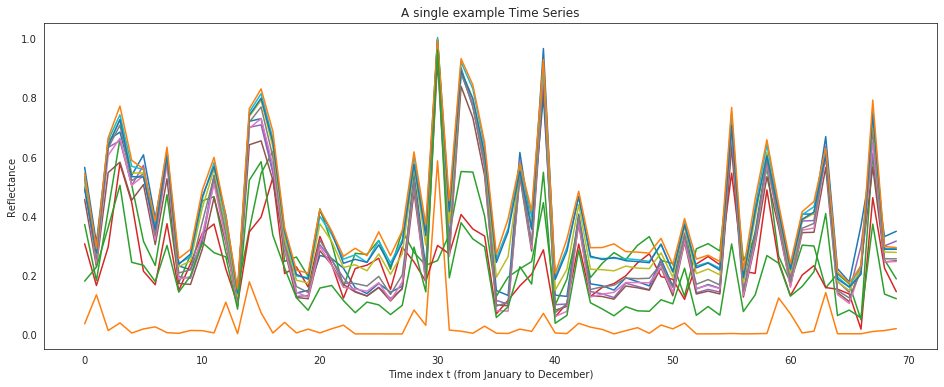

In [10]:
fld=os.path.join("/tmp")

os.makedirs(fld,exist_ok=True)

df = pd.DataFrame(x, columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(fld,"x.csv"))

np.savetxt(fld+"/x.txt", x, fmt="%.4f")

fig, ax = plt.subplots(1,figsize=(16,6))
ax.plot(x)
ax.set_title("A single example Time Series")
ax.set_ylabel("Reflectance")
ax.set_xlabel("Time index t (from January to December)")

## Initialize a Transformer model

In [18]:
hidden_dims = 128
n_heads = 3
n_layers = 3
dropout=0.262039
d_inner = hidden_dims*4
nclasses=34

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

# set transformer to eval mode
transformer.zero_grad()
transformer.eval()

TransformerEncoder(
  (inlayernorm): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
  (convlayernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (outlayernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (inconv): Conv1d(13, 128, kernel_size=(1,), stride=(1,))
  (encoder): Encoder(
    (position_enc): Embedding(71, 128)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=128, out_features=126, bias=True)
          (w_ks): Linear(in_features=128, out_features=126, bias=True)
          (w_vs): Linear(in_features=128, out_features=126, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=2)
          )
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fc): Linear(in_features=126, out_features=128, bias=True)
          (dropout): Dropout(p=0.262

## Load Pre-trained Weights

In [19]:
transformer.load("/tmp/data/transformer.pth")

loading model from /tmp/data/transformer.pth


{'optimizer_state_dict': {'state': {140610103741104: {'step': 32120,
    'exp_avg': tensor([-0.0580, -0.3054,  0.0403,  0.0332,  0.0615,  0.1096, -0.0038, -0.0643,
             0.1523, -0.0281,  0.0689, -0.1501,  0.0713]),
    'exp_avg_sq': tensor([0.0751, 0.4166, 0.1345, 0.1067, 0.1635, 0.2287, 0.4350, 0.1573, 0.2611,
            1.6990, 0.2167, 1.6023, 0.0434])},
   140610103741248: {'step': 32120,
    'exp_avg': tensor([ 0.0681,  0.2089, -0.0033, -0.0005, -0.1234, -0.1653,  0.0197,  0.0798,
             0.1725, -0.0065,  0.0559, -0.0791, -0.1310]),
    'exp_avg_sq': tensor([0.3011, 0.1490, 0.1614, 0.4504, 0.4240, 0.4495, 0.5906, 0.7689, 0.4272,
            0.8849, 0.1215, 0.6015, 0.0778])},
   140610116332568: {'step': 32120,
    'exp_avg': tensor([ 2.7595e-03,  6.5208e-03,  1.3199e-04,  4.2977e-03,  5.8357e-03,
            -4.5765e-03,  1.2398e-02, -2.5713e-03,  1.8559e-03, -1.4078e-03,
            -4.3650e-04, -3.0815e-04, -3.4290e-06, -1.8705e-03,  2.3196e-03,
            -5.5870

## Define Hooks to access the internal tensors

In [20]:
tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumred=(0.76862745,  0.28235294,  0.10588235,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumred[0],tumred[1],tumred[2],arr[o,i,0]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

def attention_hook(module, inp, out, name):
    print(name)
    
    enc_output, enc_slf_attn = out
    
    # Query, Key, Values <- all the same input for self-attention
    enc_input, enc_input, enc_input = inp
    
    os.makedirs(os.path.join(fld,name),exist_ok=True)
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt(os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
        print("writing "+os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i))
    np.savetxt(os.path.join(fld,name)+"/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_output.txt")
    np.savetxt(os.path.join(fld,name)+"/enc_input.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_input.txt")
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())
    
    save_plot(fig,os.path.join(os.path.join(fld,name),name+".pdf"))
    
    #fig.savefig(os.path.join(os.path.join(fld,name),name+".png"), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(os.path.join(fld,name),name+".png"))
    
def attention1_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-1")
    

def attention2_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-2")
    

def attention3_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-3")
    
    
def outlinear_hook(module, inp, out):
    inp = inp[0].cpu().detach().numpy()
    out = out[0].cpu().detach().numpy()
    print(out.shape)
    fig,ax = plt.subplots(1,figsize=(12,3))
    ax.bar(np.arange(out.shape[0]), np.exp(out))
    ax.set_ylabel("Score")
    ax.set_xlabel("Class")
    
    save_plot(fig,os.path.join(fld,"outlinear.png"))
    #fig.savefig(os.path.join(fld,"outlinear.png"), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(fld,"outlinear.png"))
    
def inlayernorm_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
def pos_ffn_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    

##  Attach Hooks to the Transformer Model

In [21]:
#transformer.inlayernorm.register_forward_hook(inlayernorm_hook)
transformer.encoder.layer_stack[0].slf_attn.attention.register_forward_hook(attention1_hook)
transformer.encoder.layer_stack[1].slf_attn.attention.register_forward_hook(attention2_hook)
transformer.encoder.layer_stack[2].slf_attn.attention.register_forward_hook(attention3_hook)

## Forward inference

  9%|▊         | 6/70 [00:00<00:01, 51.93it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_slf_attn_1.txt
writing /tmp/self-attention-1/enc_slf_attn_2.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt


100%|██████████| 70/70 [00:01<00:00, 39.87it/s]


writing /tmp/self-attention-1/self-attention-1.pdf


  9%|▊         | 6/70 [00:00<00:01, 54.20it/s]

self-attention-2
writing /tmp/self-attention-2/enc_slf_attn_0.txt
writing /tmp/self-attention-2/enc_slf_attn_1.txt
writing /tmp/self-attention-2/enc_slf_attn_2.txt
writing /tmp/self-attention-2/enc_output.txt
writing /tmp/self-attention-2/enc_input.txt


100%|██████████| 70/70 [00:01<00:00, 44.33it/s]


writing /tmp/self-attention-2/self-attention-2.pdf


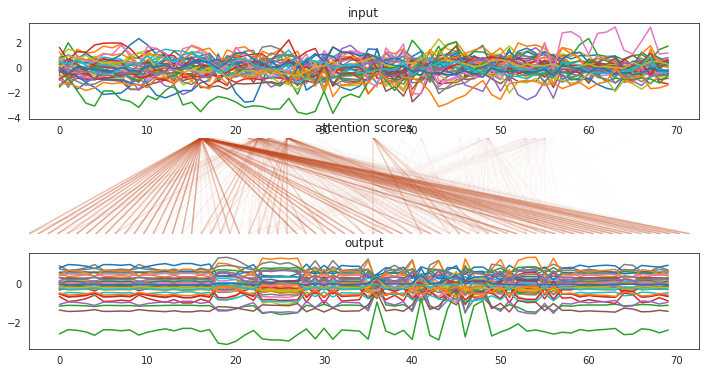

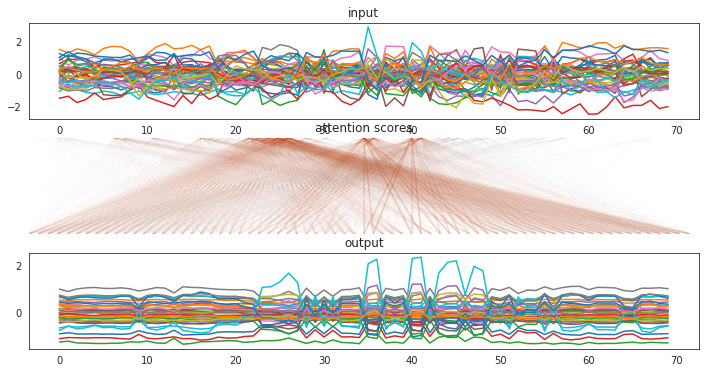

In [24]:
logprobabilities, *_ = transformer.forward(totorch(x))
probas = torch.exp(logprobabilities)

## More Visualizations

writing /tmp/attention.pdf


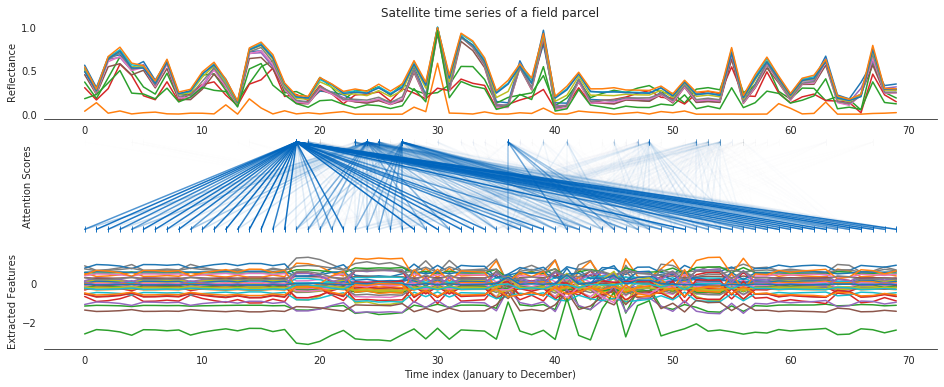

In [25]:
from matplotlib import cm

path=os.path.join(fld,"self-attention-1")

def plot_attention(path, head=0):

    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))
    enc_output = np.loadtxt(path+"/enc_output.txt")

    fig, axs = plt.subplots(3,figsize=(16,6))
    sns.despine(ax=axs[0], left=True)
    #sns.despine(ax=axs[1])
    sns.despine(ax=axs[2], left=True)

    axs[0].plot(x)
    axs[0].set_title("Satellite time series of a field parcel")
    axs[0].set_ylabel("Reflectance")
    for o in range(arr0.shape[1]):
        for i in range(arr0.shape[0]):
            axs[1].set_xlim(*axs[0].get_xlim())
            axs[1].set_ylim(-.05,1.05)
            axs[1].add_line(Line2D([i,o], [1,0],marker='|',color=(tumblue[0],tumblue[1],tumblue[2],arr0[o,i])))
            #axs[1].plot([i,o], [1,0],'r', alpha=arr0[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'g', alpha=arr1[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'b', alpha=arr2[o,i]*0.5)
    #axs[1].axis('off')
    axs[1].set_yticklabels([])
    axs[1].set_xticklabels([])
    axs[1].set_ylabel("Attention Scores")
    axs[1].set_frame_on(False)
    axs[1].grid(False)

    axs[2].plot(enc_output)
    axs[2].set_ylabel("Extracted Features")
    axs[2].set_xlabel("Time index (January to December)")

    save_plot(fig,os.path.join(fld,"attention.pdf"))

plot_attention(path)

/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


writing /tmp/self-attention-1/head0_imshow.pdf


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


writing /tmp/self-attention-1/head1_imshow.pdf


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


writing /tmp/self-attention-1/head2_imshow.pdf


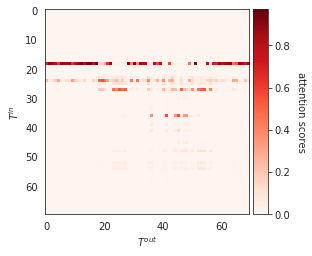

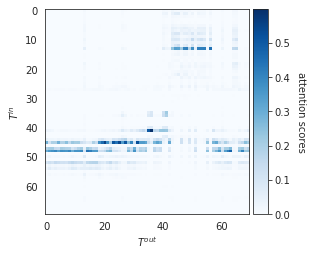

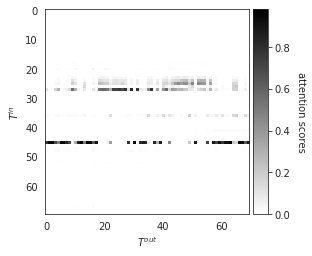

In [26]:
path=os.path.join(fld,"self-attention-1")
head=0
cmaps = ["Reds","Blues","gray_r"]
from mpl_toolkits.axes_grid1 import make_axes_locatable

for head in [0,1,2]:
    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1,1, figsize=(4,4))
    s = ax.imshow(arr0.T, cmap=cmaps[head], vmin=0, vmax=None)
    ax.set_xlabel(r'$T^{out}$')
    ax.set_ylabel(r'$T^{in}$')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad="2%")#new_horizontal(size="5%", pad=0.7, pack_start=True)
    fig.add_axes(cax)
    
    cbar = fig.colorbar(s, cax=cax, orientation='vertical')
    cbar.set_label('attention scores', rotation=270, labelpad=15)
    #ax.axis('off')
    save_plot(fig,os.path.join(path,"head{}_imshow.pdf".format(head)))
    #fig.savefig(os.path.join(path,"head{}_imshow.png".format(head)), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(path,"head0_imshow.png"))
    #fig.colorbar(s)

100%|██████████| 70/70 [00:01<00:00, 39.84it/s]


writing /tmp/self-attention-1/head0_conn.pdf


100%|██████████| 70/70 [00:01<00:00, 37.09it/s]


writing /tmp/self-attention-1/head1_conn.pdf


100%|██████████| 70/70 [00:01<00:00, 37.73it/s]


writing /tmp/self-attention-1/head2_conn.pdf


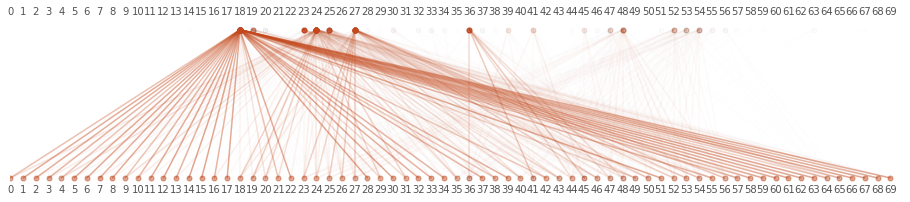

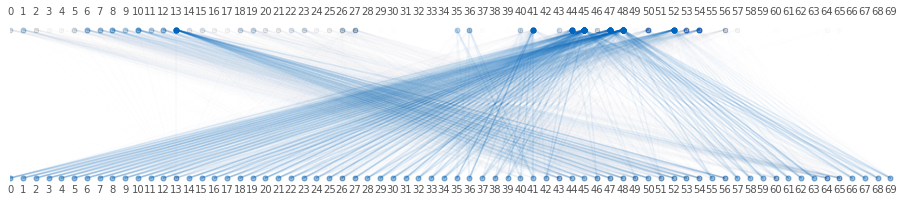

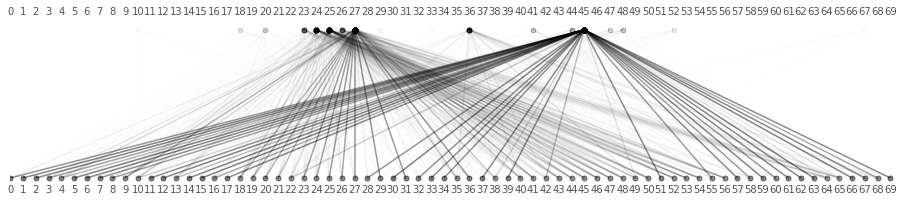

In [27]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1, figsize=(16,3))
    N = arr.shape[0]
    ax.set_xlim(0,N)
    
    for t in range(N):
        ax.text(t,1.1,str(t),alpha=0.8, ha='center')
        ax.text(t,-.1,str(t),alpha=0.8, ha='center')
    
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
    ax.axis('off')

    save_plot(fig,os.path.join(path,"head{}_conn.pdf".format(head)))
    #fig.savefig(os.path.join(path,"head{}_conn.png".format(head)), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(path,"head{}_conn.png".format(head)))

100%|██████████| 70/70 [00:02<00:00, 27.95it/s]


writing /tmp/self-attention-1/head0_conn_input.pdf


100%|██████████| 70/70 [00:01<00:00, 35.71it/s]


writing /tmp/self-attention-1/head1_conn_input.pdf


100%|██████████| 70/70 [00:01<00:00, 37.12it/s]


writing /tmp/self-attention-1/head2_conn_input.pdf


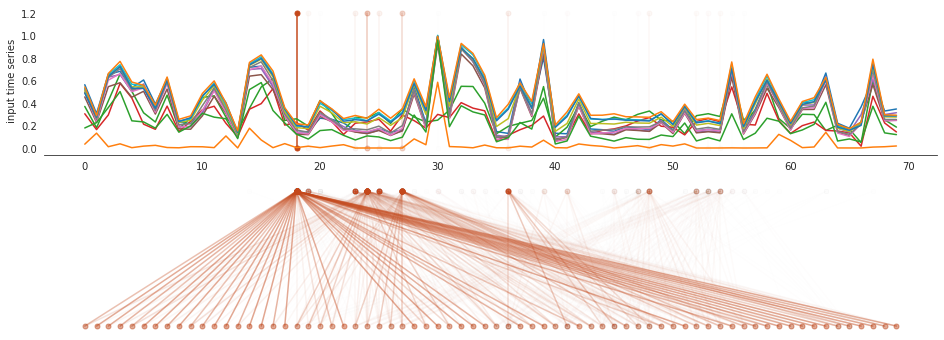

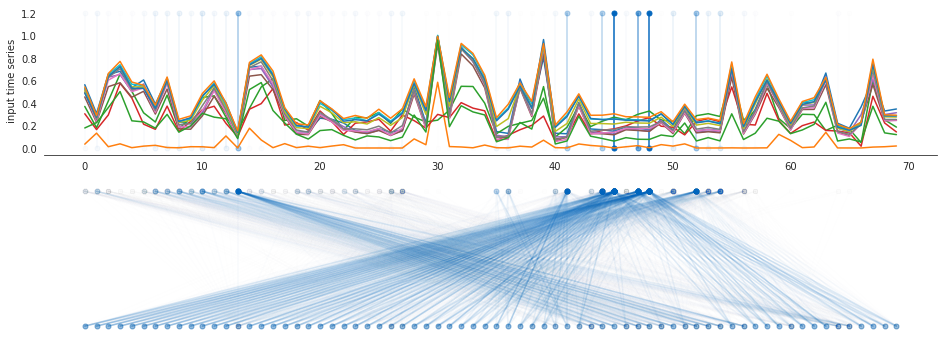

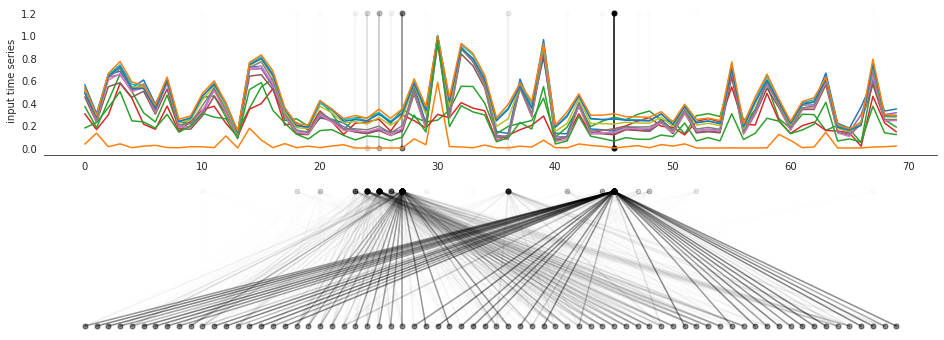

In [28]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, axs = plt.subplots(2, figsize=(16,6))
    input_focus = arr.sum(0)
    input_focus /= input_focus.max()
    for i in range(len(input_focus)):
        line=Line2D([i,i], [0,1.2] ,marker='o', markersize=5,color=(color[0],color[1],color[2],input_focus[i]))
        axs[0].add_line(line)
    
    sns.despine(ax=axs[0], left=True)
    axs[0].plot(x)
    axs[0].grid(False)
    axs[0].set_ylabel("input time series")
 
    ax = axs[1]
    ax.set_xlim(*axs[0].get_xlim())
    N = arr.shape[0]
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
    ax.axis('off')

    save_plot(fig,os.path.join(path,"head{}_conn_input.pdf".format(head)))